In [1]:
import os,sys
from collections import defaultdict
import json
import numpy as np
import pickle
import matplotlib
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

In [30]:
PATH = '/home/eddyod/programming/pipeline_utility'
MESH_DIR = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes'
sys.path.append(PATH)
from utilities.imported_atlas_utilities import load_original_volume_all_known_structures_v3, get_centroid_3d, \
    load_alignment_results_v3, transform_points, average_location, \
    convert_to_original_name, name_unsided_to_color, paired_structures, \
    convert_to_left_name, convert_to_right_name, load_original_volume_v2, save_alignment_results_v3, \
    convert_transform_forms, transform_volume_v4, volume_to_polydata, singular_structures, \
    MESH_DIR, average_shape, convert_to_surround_name, \
    save_mesh_stl, get_surround_volume_v2, transform_volume_v4, launch_vtk, actor_mesh, high_contrast_colors, \
    add_axes, plot_centroid_means_and_covars_3d, all_known_structures_sided
from utilities.aligner_v3 import Aligner

In [3]:
INPUT_KEY_LOC = os.path.join(PATH, 'neuroglancer', 'structure_key_minimal.json')
NUM_STRUCTS = 49
with open(INPUT_KEY_LOC, 'r') as f:
    structures = json.load(f)
structures = list(structures.values())
structures = structures[0:9]

In [4]:
structures

['10N_L', '10N_R', '12N', '3N_L', '3N_R', '4N_L', '4N_R', '5N_L', '5N_R']

In [5]:
atlas_name = 'atlasV7'
fixed_brain_name = 'MD589'
moving_brain_names = ['MD585', 'MD594']
resolution = '10.0um'
resolution_um = 10.0
structure_centroids_all_brains_um_wrt_fixed = []
fixed_brain_spec = {'name': fixed_brain_name, 'vol_type': 'annotationAsScore', 'resolution': resolution}

In [6]:
fixed_brain = load_original_volume_all_known_structures_v3(stack_spec=fixed_brain_spec, structures=structures)
fixed_brain_structure_centroids = get_centroid_3d(fixed_brain)
print('fixed_brain_structure_centroids', fixed_brain_structure_centroids)
fixed_brain_structure_centroids_um = {s: c * resolution_um for s, c in fixed_brain_structure_centroids.items()}
print('fixed_brain_structure_centroids_um', fixed_brain_structure_centroids_um)
structure_centroids_all_brains_um_wrt_fixed.append(fixed_brain_structure_centroids_um)

Prior structure/index map not found. Generating a new one.


fixed_brain_structure_centroids {'10N_L': array([1377.9323021 ,  600.54621743,  422.01120992]), '10N_R': array([1377.78125193,  600.98146203,  478.83958475]), '12N': array([1365.88068653,  615.20999364,  452.5142025 ]), '3N_L': array([1060.76684485,  440.31618706,  442.33235172]), '3N_R': array([1062.71309218,  440.81977598,  467.55040397]), '4N_L': array([1094.23971377,  449.07513417,  418.41144902]), '4N_R': array([1094.19370861,  447.37251656,  472.13576159]), '5N_L': array([1135.63803623,  570.75503797,  318.95509957]), '5N_R': array([1127.76469797,  554.34528704,  598.29166346])}
fixed_brain_structure_centroids_um {'10N_L': array([13779.32302104,  6005.46217435,  4220.1120992 ]), '10N_R': array([13777.81251931,  6009.81462028,  4788.39584749]), '12N': array([13658.80686535,  6152.09993636,  4525.14202502]), '3N_L': array([10607.66844851,  4403.16187062,  4423.32351717]), '3N_R': array([10627.13092178,  4408.19775982,  4675.50403966]), '4N_L': array([10942.39713775,  4490.75134168,

## Compute instance centroids

In [7]:
for brain_m in moving_brain_names:
    moving_brain_spec = {'name': brain_m, 'vol_type': 'annotationAsScore', 'resolution': resolution}
    print('Brain', moving_brain_spec)
    moving_brain = load_original_volume_all_known_structures_v3(stack_spec=moving_brain_spec, structures=structures)
    alignment_spec = dict(stack_m=moving_brain_spec, stack_f=fixed_brain_spec, warp_setting=109)
    moving_brain_structure_centroids_input_resol = get_centroid_3d(moving_brain)
    # Load registration.
    # Alignment results fp: os.path.join(reg_root_dir, alignment_spec['stack_m']['name'], warp_basename, warp_basename + '_' + what + '.' + ext)
    transform_parameters_moving_brain_to_fixed_brain = load_alignment_results_v3(alignment_spec=alignment_spec, what='parameters')
    # Transform moving brains into alignment with the fixed brain.
    transformed_moving_brain_structure_centroids_input_resol_wrt_fixed = \
    dict(list(zip(list(moving_brain_structure_centroids_input_resol.keys()),
                  transform_points(pts=list(moving_brain_structure_centroids_input_resol.values()),
                                   transform=transform_parameters_moving_brain_to_fixed_brain))))

    transformed_moving_brain_structure_centroids_um_wrt_fixed = \
        {s: c * resolution_um for s, c in
        list(transformed_moving_brain_structure_centroids_input_resol_wrt_fixed.items())}

    structure_centroids_all_brains_um_wrt_fixed.append(transformed_moving_brain_structure_centroids_um_wrt_fixed)


Brain {'name': 'MD585', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}


Prior structure/index map not found. Generating a new one.


Brain {'name': 'MD594', 'vol_type': 'annotationAsScore', 'resolution': '10.0um'}


Prior structure/index map not found. Generating a new one.


In [8]:
structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed = defaultdict(list)
for sc in structure_centroids_all_brains_um_wrt_fixed:
    for k, c in sc.items():
        structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed[k].append(c)
structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed.default_factory = None

## Compute standard centroids

In [9]:
nominal_centroids_wrt_canonicalAtlasSpace_um, \
instance_centroids_wrt_canonicalAtlasSpace_um, \
canonical_center_wrt_fixed_um, \
canonical_normal, \
transform_matrix_to_canonicalAtlasSpace_um = \
average_location(structure_centroids_all_brains_um_grouped_by_structure_wrt_fixed)

('Mid-sagittal plane normal vector =', array([ 0.04541714, -0.09275103,  0.99465297]), '@ Mid-sagittal plane anchor wrt fixed wholebrain =', array([12110.9375988 ,  5458.61608015,  4611.96402947]))
('Angular deviation of the mid sagittal plane normal around y axis (degree) =', 5.927719704050841)


In [10]:
colors = {name_s: np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255.
                                        for name_s in instance_centroids_wrt_canonicalAtlasSpace_um.keys()}

No handles with labels found to put in legend.


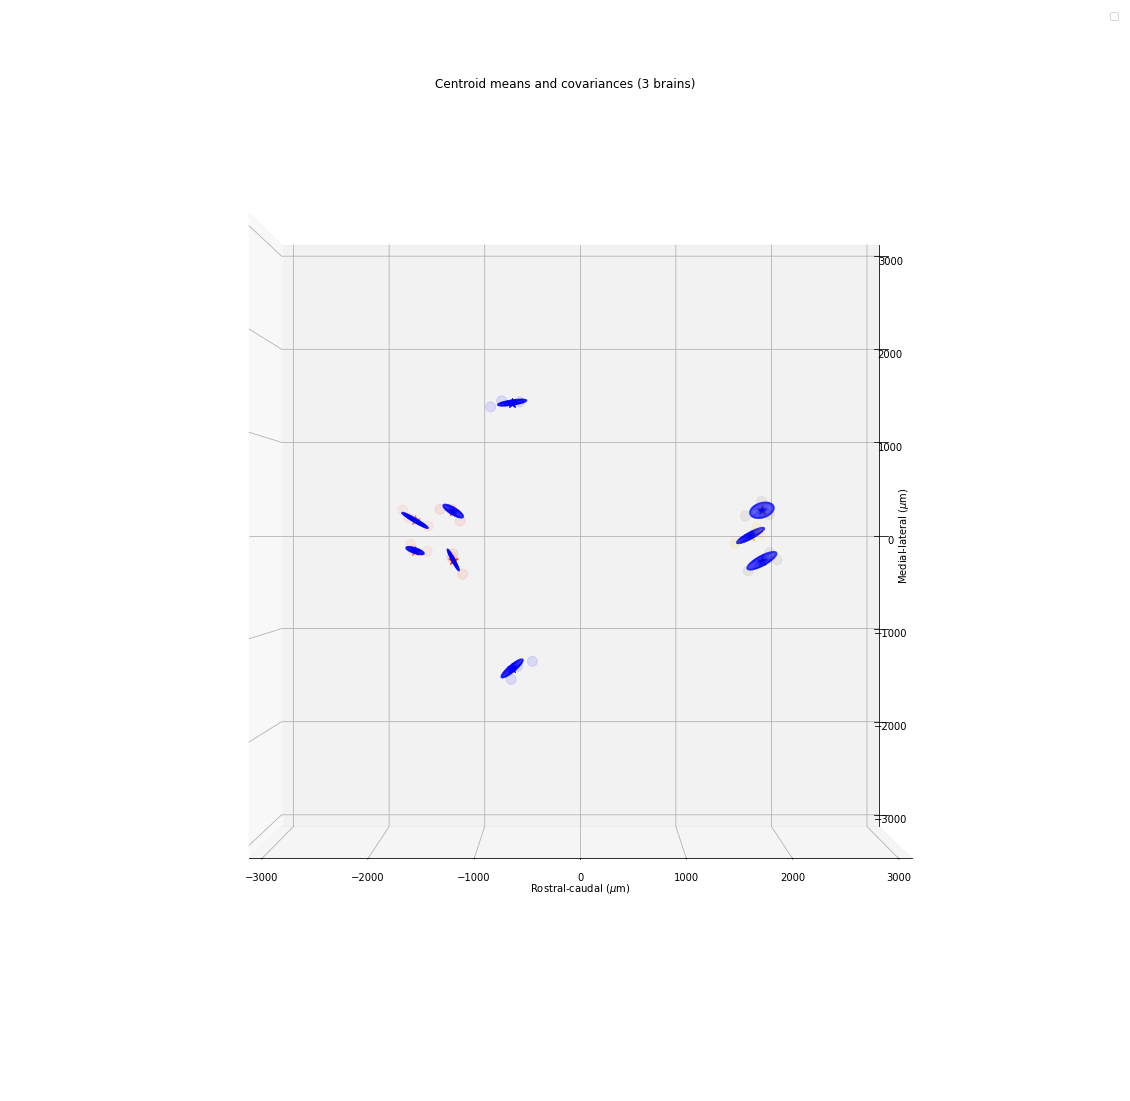

In [13]:
plot_centroid_means_and_covars_3d(instance_centroids=instance_centroids_wrt_canonicalAtlasSpace_um,
                                 nominal_locations=nominal_centroids_wrt_canonicalAtlasSpace_um,
                                 canonical_centroid=(0,0,0),
                                  show_canonical_centroid=False,
                                  canonical_normal=[0,0,1],
                                 colors=colors,
                                 xlim=[-3000, 3000],
                                 ylim=[-3000, 3000],
                                 zlim=[-3000, 3000],
                                 xlabel='Rostral-caudal ($\mu$m)',
                                 ylabel='',
                                 zlabel='Medial-lateral ($\mu$m)',
                                 title='Centroid means and covariances (3 brains)')

In [14]:
filepath = os.path.join(MESH_DIR, 'atlasV7', '1um_meanPositions.pkl')
with open(filepath, 'wb') as f:
    pickle.dump(nominal_centroids_wrt_canonicalAtlasSpace_um, f)

In [15]:
filepath = os.path.join(MESH_DIR, 'atlasV7', 'canonicalCentroid_wrt_fixedWholebrain.txt')
np.savetxt(filepath, canonical_center_wrt_fixed_um)

In [16]:
reg_root_dir=os.path.join(MESH_DIR, atlas_name, 'mean_shapes', 'instance_registration')

In [17]:
# Note that all shapes have voxel resolution matching input resolution (10.0 micron).
for structure in ['12N']:
    # for structure in all_known_structures:
    # Load instance volumes.
    instance_volumes = []
    instance_source = []

    if structure in paired_structures:
        left_name = convert_to_left_name(structure)
        right_name = convert_to_right_name(structure)
    else:
        left_name = structure
        right_name = structure

    for brain_name in [fixed_brain_name] + moving_brain_names:
        brain_spec = {'name': brain_name, 'vol_type': 'annotationAsScore', 'resolution': resolution}
        right_instance_vol, _ = load_original_volume_v2(stack_spec=brain_spec,
                                                        structure=right_name,
                                                        return_origin_instead_of_bbox=True,
                                                        crop_to_minimal=True)
        instance_volumes.append(right_instance_vol)  # if right, do not mirror
        instance_source.append((brain_name, 'R'))

        left_instance_vol, _ = load_original_volume_v2(stack_spec=brain_spec,
                                                       structure=left_name,
                                                       return_origin_instead_of_bbox=True,
                                                       crop_to_minimal=True)
        instance_volumes.append(left_instance_vol[..., ::-1])  # if left, mirror
        instance_source.append((brain_name, 'L'))

   # Use the first instance as registration target.
    # Register every other instance to the first instance.
    template_instance_volume = instance_volumes[0]
    template_instance_centroid_wrt_templateOrigin = get_centroid_3d(template_instance_volume).astype(np.int16)
    template_instance_wrt_templateCentroid = (template_instance_volume, - template_instance_centroid_wrt_templateOrigin)
    aligned_moving_instance_wrt_templateCentroid_all_instances = []

    for i in range(1, len(instance_volumes)):
        print('Registering {} instance {} to instance 0'.format(structure, i))
        # Compute transform.
        moving_instance_volume = instance_volumes[i]
        aligner = Aligner({0: template_instance_wrt_templateCentroid},
                          {0: (moving_instance_volume, np.array((0,0,0)))},
                          labelIndexMap_m2f={0:0},
                         verbose=False)
        aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid')
        aligner.compute_gradient(smooth_first=True)
        lr = 1.
        ### max_iter_num was originally 100 and 1000
        print('Entering aligner optimzer')
        _, _ = aligner.optimize(tf_type='rigid',
                                history_len=100,
                                max_iter_num=2 if structure in ['SC', 'IC'] else 3,
                                grad_computation_sample_number=None,
                                full_lr=np.array([lr, lr, lr, 0.1, 0.1, 0.1]),
                                terminate_thresh_trans=.01)



        reg_root_dir=os.path.join(MESH_DIR, atlas_name, 'mean_shapes', 'instance_registration')
        save_alignment_results_v3(aligner=aligner,
                              select_best='max_value',
                              alignment_spec=dict(warp_setting=108,
                                                  stack_f=dict(name='%s_instance0' % structure, vol_type='annotationAsScore'),
                                                  stack_m=dict(name='%s_instance%d' % (structure, i),
                                                               vol_type='annotationAsScore')),
                              reg_root_dir=reg_root_dir)

        # Transform instances.
        T = convert_transform_forms(aligner=aligner, out_form=(3, 4), select_best='max_value')
        aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid = \
            transform_volume_v4(volume=(moving_instance_volume, (0, 0, 0)), transform=T,
                                return_origin_instead_of_bbox=True)
        aligned_moving_instance_wrt_templateCentroid = (
        aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid)
        aligned_moving_instance_wrt_templateCentroid_all_instances.append(aligned_moving_instance_wrt_templateCentroid)

    # Generate meshes for each instance.
    volume_origin_list = [template_instance_wrt_templateCentroid] + aligned_moving_instance_wrt_templateCentroid_all_instances
    instance_mesh_wrt_templateCentroid_all_instances = [volume_to_polydata(volume, num_simplify_iter=3, smooth=True)
        for volume, o in volume_origin_list]

    # Save meshes.
    for i, mesh_data in enumerate(instance_mesh_wrt_templateCentroid_all_instances):
        meshfile = '{}_{}_{}.stl'.format(resolution, structure, str(i))
        meshpath = os.path.join(MESH_DIR, atlas_name, 'aligned_instance_meshes', meshfile)
        #print('Save stl at {}'.format( meshpath))
        save_mesh_stl(mesh_data, meshpath)

    filename = '{}_sources.pkl'.format(structure)
    filepath = os.path.join(MESH_DIR, atlas_name, 'instance_sources', filename)
    with open(filepath, 'wb') as f:
        pickle.dump(instance_source, f)

    # Compute average shape.

    if structure == 'IC' or structure == 'SC':
        # IC and SC boundaries are particularly jagged, so do a larger value smoothing.
        sigma = 5.
    else:
        sigma = 2.


    mean_shape_wrt_templateCentroid = \
        average_shape(volume_origin_list=volume_origin_list, force_symmetric=(structure in singular_structures),
                      sigma=sigma,
                      )

    for surface_level in np.arange(0.1, 1.1, .1):
        print("level =", surface_level, ', volume =',
              np.count_nonzero(mean_shape_wrt_templateCentroid[0] > surface_level) * resolution_um ** 3 / 1e9, "mm^3")

    # Generate meshes for mean shape.
    mean_shape_isosurface_polydata_all_levels = {surface_level:
                                                     volume_to_polydata(
                                                         (mean_shape_wrt_templateCentroid[0] >= surface_level,
                                                         mean_shape_wrt_templateCentroid[1]),
                                                         num_simplify_iter=3, smooth=True)
        for surface_level in np.arange(0.1, 1.1, .1)}

    # Identify the surrouding area as additional structure.

    wall_level = .5
    surround_distance_um = 200.

    # changed to v2 to v3 Jul/27/2020 renamed without the _vX
    # volume, distance=5, wall_level=0, prob=False, return_origin_instead_of_bbox=True, padding=5
    # def get_surround_volume(volume, origin, distance=5, wall_level=0, prob=False, return_origin_instead_of_bbox=True,
    #                        padding=5):
    surround_wrt_stdShapeCentroid = \
        get_surround_volume_v2(vol=mean_shape_wrt_templateCentroid[0],
                               origin=mean_shape_wrt_templateCentroid[1],
                               distance=surround_distance_um / resolution_um,
                               wall_level=wall_level,
                               prob=True,
                               return_origin_instead_of_bbox=True,
                               padding=5)

    # Generate meshes for surrouding area.
    surround_isosurface_polydata_all_levels = {surface_level:
             volume_to_polydata((surround_wrt_stdShapeCentroid[0] >= surface_level,
                                surround_wrt_stdShapeCentroid[1]),
                                num_simplify_iter=3, smooth=True)
         for surface_level in np.arange(0.1, 1.1, .1)}

    # Save mean shape.
    filename = '{}_{}_volume.npy'.format(resolution, structure)
    filepath =  os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
    print('Saving numpy array at', filepath)
    np.save(filepath, np.ascontiguousarray(mean_shape_wrt_templateCentroid[0]))

    filename = '{}_{}_origin_wrt_meanShapeCentroid.txt'.format(resolution, structure)
    filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
    print('Saving numpy text at', filepath)
    np.savetxt(filepath, mean_shape_wrt_templateCentroid[1])


    for level in np.arange(0.1, 1.1, .1):
        filename = '{}_{}_mesh_level_{}.stl'.format(resolution, structure, str(level))
        filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
        print('Saving mesh at', filepath)
        save_mesh_stl(mean_shape_isosurface_polydata_all_levels[level], filepath)

    surround_name = convert_to_surround_name(structure, margin=str(int(surround_distance_um)) + 'um')
    filename = '{}_{}_volume.npy'.format(resolution, surround_name)
    filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
    print('Saving numpy array at', filepath)
    np.save(filepath, np.ascontiguousarray(surround_wrt_stdShapeCentroid[0]))


    filename = '{}_{}_origin_wrt_meanShapeCentroid.txt'.format(resolution, surround_name)
    filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
    print('Saving numpy text at', filepath)
    np.savetxt(filepath, surround_wrt_stdShapeCentroid[1])

    for level in np.arange(0.1, 1.1, .1):
        filename = '{}_{}_{}.stl'.format(resolution, surround_name, str(level))
        filepath = os.path.join(MESH_DIR, atlas_name, 'mean_shapes', filename)
        print('Saving mesh at', filepath)
        save_mesh_stl(surround_isosurface_polydata_all_levels[level], filepath)


Registering 12N instance 1 to instance 0
Entering aligner optimzer
score: 0.11750000000000005
grad: [  -15.65270698    32.92642665   -41.8894977   2369.08890551
 -2008.67451358   265.18147546]
[-1.   1.  -1.   0.1 -0.1  0.1]
[1.  1.  1.  0.1 0.1 0.1]
[-1.  1. -1.  1. -1.  1.]
score: 0.11705700000000004
grad: [   329.30949849   -443.41357726     31.86357081  -3254.10877657
  -1641.16670966 -21918.62573457]
[ 0.99887227 -0.99725432  0.60541505 -0.08084448 -0.06327078 -0.09999268]
[1.  1.  1.  0.1 0.1 0.1]
[ 0.99887227 -0.99725432  0.60541505 -0.80844476 -0.63270782 -0.99992682]


Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [54.88068653 35.20999364 36.4857975 ], centroid_f: [0.88068653 0.20999364 0.5142025 ]
indices_f: {0}


score: 0.122365
grad: [-3.64077818e+00  6.55209564e+01 -1.91615321e+02  9.31921820e+03
  7.09689496e+03 -4.90260422e+02]
[-0.01104265  0.14578483 -0.96428674  0.09180287  0.09392316 -0.00223601]
[1.  1.  1.  0.1 0.1 0.1]
[-0.01104265  0.14578483 -0.96428674  0.91802869  0.93923158 -0.02236007]
Registering 12N instance 2 to instance 0


/home/eddyod/programming/pipeline_utility/utilities/imported_atlas_utilities.py:3073: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(volume_m_aligned_to_f.dtype, np.float):
/home/eddyod/programming/pipeline_utility/utilities/imported_atlas_utilities.py:3080: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  elif np.issubdtype(volume_m_aligned_to_f.dtype, bool):
Interpolating/filling sparse volume: 0.03 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [48.06545396 41.91409558 38.59259027], centroid_f: [0.88068653 0.20999364 0.5142025 ]
indices_f: {0}


Entering aligner optimzer
score: 0.115403
grad: [ 4.32954624e+01 -1.52532057e+01  2.69629859e+02 -1.58195508e+04
 -8.66324933e+03 -1.45199700e+04]
[ 1.  -1.   1.  -0.1 -0.1 -0.1]
[1.  1.  1.  0.1 0.1 0.1]
[ 1. -1.  1. -1. -1. -1.]
score: 0.121324
grad: [-3.55771847e+02  6.64515003e+02 -6.32304919e+00 -1.74432124e+03
  3.60885679e+03  1.12232341e+04]
[-0.99267647  0.99973666 -0.0234444  -0.01095994  0.038454    0.06115586]
[1.  1.  1.  0.1 0.1 0.1]
[-0.99267647  0.99973666 -0.0234444  -0.10959939  0.38453999  0.61155863]
score: 0.12549200000000002
grad: [  -47.03200698   155.68815023     7.56109446 -2344.53954971
  1809.57205451 -6210.34813815]
[-0.13011339  0.22805444  0.02802378 -0.01457395  0.01893306 -0.03205476]
[1.  1.  1.  0.1 0.1 0.1]
[-0.13011339  0.22805444  0.02802378 -0.14573952  0.18933065 -0.32054763]


Interpolating/filling sparse volume: 0.03 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [48.06545396 41.91409558 35.40740973], centroid_f: [0.88068653 0.20999364 0.5142025 ]
indices_f: {0}


Registering 12N instance 3 to instance 0
Entering aligner optimzer
score: 0.11272100000000002
grad: [   109.17941839   -127.52642894   -242.77325916  13989.26722664
   7578.49685818 -10493.1352191 ]
[ 1.  -1.  -1.   0.1  0.1 -0.1]
[1.  1.  1.  0.1 0.1 0.1]
[ 1. -1. -1.  1.  1. -1.]
score: 0.11779800000000003
grad: [ -340.60346061   645.12734067    41.39444602   599.6989249
 -3531.8509571  12128.60194087]
[-0.95227283  0.9810166   0.16808085  0.00428292 -0.04224159  0.07562541]
[1.  1.  1.  0.1 0.1 0.1]
[-0.95227283  0.9810166   0.16808085  0.04282917 -0.42241586  0.75625415]
score: 0.12127200000000002
grad: [  -18.47385347   106.66802084   -12.78950983  2151.39807773
 -1930.03990787 -8061.43839324]
[-0.05158118  0.16011269 -0.05186152  0.01518659 -0.02249216 -0.044911  ]
[1.  1.  1.  0.1 0.1 0.1]
[-0.05158118  0.16011269 -0.05186152  0.15186593 -0.22492157 -0.44910997]


Interpolating/filling sparse volume: 0.03 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [56.4252816  26.79680604 38.9413976 ], centroid_f: [0.88068653 0.20999364 0.5142025 ]
indices_f: {0}


Registering 12N instance 4 to instance 0
Entering aligner optimzer
score: 0.10714900000000001
grad: [ 2.91321651e+01  1.24834191e+02 -5.70366430e+00  3.46548259e+03
  2.35858834e+03  3.68320451e+04]
[ 1.   1.  -1.   0.1  0.1  0.1]
[1.  1.  1.  0.1 0.1 0.1]
[ 1.  1. -1.  1.  1.  1.]
score: 0.11853800000000002
grad: [-2.83330184e+00 -7.15956533e+00  2.82344916e+02 -1.18536492e+04
 -8.29614721e+03  1.85349814e+04]
[-0.09680009 -0.05725851  0.99979602 -0.0959822  -0.09618827  0.04495201]
[1.  1.  1.  0.1 0.1 0.1]
[-0.09680009 -0.05725851  0.99979602 -0.95982202 -0.96188266  0.44952015]
score: 0.12493400000000005
grad: [ 8.74350983e+00 -3.71073092e+01 -9.49546993e-01  2.02284937e+03
  2.94741772e+03  1.30478179e+04]
[ 0.28622518 -0.28450146 -0.00336237  0.01616416  0.03233726  0.03016975]
[1.  1.  1.  0.1 0.1 0.1]
[ 0.28622518 -0.28450146 -0.00336237  0.16164159  0.32337259  0.30169751]


Interpolating/filling sparse volume: 0.03 seconds.
Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [56.4252816  26.79680604 39.0586024 ], centroid_f: [0.88068653 0.20999364 0.5142025 ]
indices_f: {0}


Registering 12N instance 5 to instance 0
Entering aligner optimzer
score: 0.10659099999999999
grad: [1.10306860e+01 1.40121405e+02 1.52420088e+01 7.25147965e+02
 1.10136880e+03 3.46962379e+04]
[1.  1.  1.  0.1 0.1 0.1]
[1.  1.  1.  0.1 0.1 0.1]
[1. 1. 1. 1. 1. 1.]
score: 0.113463
grad: [   -30.61600292     82.28498417    180.73880738 -12940.30779833
  -7868.01563984  15353.6059218 ]
[-0.94079998  0.50638278  0.99646294 -0.09984336 -0.09903444  0.04046646]
[1.  1.  1.  0.1 0.1 0.1]
[-0.94079998  0.50638278  0.99646294 -0.99843356 -0.9903444   0.40466457]
score: 0.11825800000000002
grad: [ 238.06873739 -375.05279392 -105.23242301 1244.96612    2214.75527179
 9552.60410786]
[ 0.99078632 -0.91757995 -0.50183161  0.00956176  0.02685315  0.02441521]
[1.  1.  1.  0.1 0.1 0.1]
[ 0.99078632 -0.91757995 -0.50183161  0.09561756  0.26853149  0.24415213]


Interpolating/filling sparse volume: 0.03 seconds.
marching cube: 0.03 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 27865: 0.23 seconds
simplify 1 @ 5574: 0.22 seconds
simplify 2 @ 1116: 0.04 seconds
marching cube: 0.03 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 29028: 0.20 seconds
simplify 1 @ 5807: 0.25 seconds
simplify 2 @ 1163: 0.05 seconds
marching cube: 0.03 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 28859: 0.20 seconds
simplify 1 @ 5771: 0.25 seconds
simplify 2 @ 1156: 0.04 seconds
marching cube: 0.03 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 28643: 0.19 seconds
simplify 1 @ 5731: 0.23 seconds
simplify 2 @ 1147: 0.04 seconds
marching cube: 0.04 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 28361: 0.19 seconds
simplify 1 @ 5673: 0.23 seconds
simplify 2 @ 1136: 0.04 seconds
marching cube: 0.04 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 28030: 0.20 seconds
simplify 1 @ 5608: 0.23 seconds
simplify 2 @ 1123: 0.04 seconds
marching cube

level = 0.1 , volume = 0.128242 mm^3
level = 0.2 , volume = 0.113269 mm^3
level = 0.30000000000000004 , volume = 0.103154 mm^3
level = 0.4 , volume = 0.094851 mm^3
level = 0.5 , volume = 0.087315 mm^3
level = 0.6 , volume = 0.080055 mm^3
level = 0.7000000000000001 , volume = 0.072614 mm^3
level = 0.8 , volume = 0.064194 mm^3
level = 0.9 , volume = 0.053205 mm^3
level = 1.0 , volume = 0.0 mm^3


simplify 0 @ 22107: 0.14 seconds
simplify 1 @ 4423: 0.16 seconds
simplify 2 @ 886: 0.03 seconds
marching cube: 0.04 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 20909: 0.13 seconds
simplify 1 @ 4183: 0.15 seconds
simplify 2 @ 838: 0.03 seconds
marching cube: 0.04 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 20301: 0.12 seconds
simplify 1 @ 4061: 0.15 seconds
simplify 2 @ 813: 0.03 seconds
marching cube: 0.04 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 19491: 0.12 seconds
simplify 1 @ 3899: 0.14 seconds
simplify 2 @ 781: 0.03 seconds
marching cube: 0.04 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 18949: 0.12 seconds
simplify 1 @ 3791: 0.20 seconds
simplify 2 @ 759: 0.03 seconds
marching cube: 0.04 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 18305: 0.12 seconds
simplify 1 @ 3662: 0.15 seconds
simplify 2 @ 734: 0.03 seconds
marching cube: 0.04 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 17689: 0.11 seconds
simplify 1 @ 3539: 0.14 seconds
simpl

Saving numpy array at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_12N_volume.npy
Saving numpy text at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_12N_origin_wrt_meanShapeCentroid.txt
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_12N_mesh_level_0.1.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_12N_mesh_level_0.2.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_12N_mesh_level_0.30000000000000004.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_12N_mesh_level_0.4.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_12N_mesh_level_0.5.stl
Saving mesh at /net/birdstore/Active_Atlas_Data/data_root/CSHL_meshes/atlasV7/mean_shapes/10.0um_12N_mesh_level_0.6.stl
Savin

In [ ]:
i = 1
# Compute transform.
moving_instance_volume = instance_volumes[i]
aligner = Aligner({0: template_instance_wrt_templateCentroid}, 
                  {0: (moving_instance_volume, np.array((0,0,0)))}, 
                  labelIndexMap_m2f={0:0})
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid')
aligner.compute_gradient(smooth_first=True)
lr = .1
_, _ = aligner.optimize(tf_type='rigid', 
                     history_len=100, 
                    max_iter_num=100 if structure in ['SC', 'IC'] else 10000,
                     grad_computation_sample_number=None,
                        full_lr=np.array([lr,lr,lr,0.1,0.1,0.1]),
                       terminate_thresh_trans=.01)

In [ ]:
plt.plot(aligner.Ts);

In [ ]:
plt.plot(aligner.scores);

In [ ]:
[[  9.69838248e-01   7.41253856e-02   2.32205080e-01  -3.58975061e+01]
 [ -7.00849620e-02   9.97212129e-01  -2.56138103e-02  -3.87932318e+01]
 [ -2.33456356e-01   8.56716872e-03   9.72329540e-01  -1.27806610e+01]]

In [ ]:
# Transform instances.
T = convert_transform_forms(aligner=aligner, out_form=(3,4), select_best='max_value')

aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid = \
transform_volume_v4((moving_instance_volume, (0,0,0)), transform=T,
                    return_origin_instead_of_bbox=True)

aligned_moving_instance_wrt_templateCentroid = (aligned_moving_instance_volume, aligned_moving_instance_origin_wrt_templateCentroid)        

# Generate meshes for each instance.

instance_mesh_wrt_templateCentroid_all_instances = [
volume_to_polydata((v, o), num_simplify_iter=3, smooth=True)
for v, o in 
[template_instance_wrt_templateCentroid] + [aligned_moving_instance_wrt_templateCentroid]]

launch_vtk([actor_mesh(mesh, wireframe=True, color=np.array(high_contrast_colors[i+1])/255., opacity=1) 
    for i, mesh in enumerate([instance_mesh_wrt_templateCentroid_all_instances[0],
                             instance_mesh_wrt_templateCentroid_all_instances[1]])], 
  background_color=(1,1,1))

# Visualize Results

In [ ]:
# for name_u in all_known_structures:
for name_u in ['5N']:
    fig, axes = plt.subplots(1, 5,squeeze=True, figsize=(20,2));
    for i in range(1, 6):
#         try:
        scores = DataManager.load_alignment_results_v3( what='scoreHistory',
      alignment_spec=dict(warp_setting=108, 
                          stack_f=dict(name='%s_instance0' % name_u, vol_type='annotationAsScore'),
                         stack_m=dict(name='%s_instance%d' % (name_u, i), vol_type='annotationAsScore')),
                 reg_root_dir=os.path.join(MESH_ROOTDIR, atlas_name, 'mean_shapes', 'instance_registration'))        
        axes[i-1].plot(scores);
        axes[i-1].set_title('%s_instance%d' % (name_u, i))
#         except:
#             pass
    plt.show();

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 8: invalid start byte

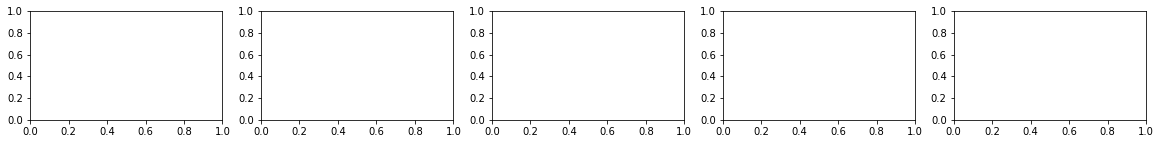

In [21]:
# for name_u in all_known_structures:
for name_u in ['12N']:
    fig, axes = plt.subplots(1, 5,squeeze=True, figsize=(20,2));
    for i in range(1, 6):
        trajectory = load_alignment_results_v3(what='trajectory',
                          alignment_spec=dict(warp_setting=108, 
                                              stack_f=dict(name='%s_instance0' % name_u, vol_type='annotationAsScore'),
                                             stack_m=dict(name='%s_instance%d' % (name_u, i), vol_type='annotationAsScore')),
                                     reg_root_dir=os.path.join(MESH_DIR, atlas_name, 'mean_shapes', 'instance_registration'))        
        axes[i-1].plot(trajectory);
        axes[i-1].set_title('%s_instance%d' % (name_u, i))
    plt.show();

In [ ]:
for name_u in all_known_structures:

    # Load instance meshes.
    
    instance_meshes = []
    for i in range(6):
        m = load_data(DataManager.get_instance_mesh_filepath(atlas_name=atlas_name, structure=name_u, 
                                                         index=i, resolution='10um'))
        if m is not None:
            instance_meshes.append(m)

    launch_vtk([actor_mesh(m, wireframe=True, 
                           color=np.array(high_contrast_colors[i+1])/255., 
                           opacity=1, wireframe_linewidth=3) 
        for i, m in enumerate(instance_meshes)], 
      background_color=(1,1,1))
    
    # Load average shape.
    
    vol = load_data(DataManager.get_mean_shape_filepath(atlas_name=atlas_name, structure=name_u, what='volume', resolution='10.0um'))
    ori_wrt_meanShapeCentroid = load_data(DataManager.get_mean_shape_filepath(atlas_name=atlas_name, structure=name_u, what='origin_wrt_meanShapeCentroid', resolution='10.0um'))
    
    standard_shape_volume_actor = actor_volume(vol.astype(np.float32), 
                                               what='probability', 
                                               origin=ori_wrt_meanShapeCentroid, 
                                              c=(0,0,0))
    
    launch_vtk([standard_shape_volume_actor])

# Combine standard shapes with standard centroid locations

In [ ]:
atlas_resolution = '10.0um'
atlas_resolution_um = convert_resolution_string_to_um(atlas_resolution)

In [ ]:
nominal_centroids_wrt_canonicalAtlasSpace_um = load_data(DataManager.get_structure_mean_positions_filepath(atlas_name=atlas_name, resolution='1um'))
nominal_centroids_wrt_canonicalAtlasSpace_10um = {s: c / atlas_resolution_um for s, c in nominal_centroids_wrt_canonicalAtlasSpace_um.iteritems()}

mean_shapes_10um_wrt_stdShapeCentroid = {name_u: DataManager.load_mean_shape(atlas_name=atlas_name, structure=name_u, resolution=atlas_resolution) 
                    for name_u in all_known_structures_unsided_including_surround_200um}

In [ ]:
atlas_spec = dict(name='atlasV6', vol_type='score', resolution=atlas_resolution)

In [ ]:
## TODO: simplify this.

# mean_shape_wrt_canonicalAtlasSpace_all_structures_10um = {}

for name_u in all_known_structures:
# for name_u in ['7N']:
      
#     mean_shape_10um, mean_shape_origin_wrt_stdShapeCentroid_10um = mean_shapes_10um_wrt_stdShapeCentroid[name_u]
#     mean_shape_surround_10um, mean_shape_surround_origin_wrt_stdShapeCentroid_10um = mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')]
    
    if name_u in singular_structures:
                
        for name in [name_u, convert_to_surround_name(name_u, margin='200um')]:
            
            mean_shape_wrt_canonicalAtlasSpace_10um = (mean_shapes_10um_wrt_stdShapeCentroid[name][0], 
                        mean_shapes_10um_wrt_stdShapeCentroid[name][1] + nominal_centroids_wrt_canonicalAtlasSpace_10um[name_u])
            
#             mean_shape_wrt_canonicalAtlasSpace_all_structures_10um[name] = mean_shape_wrt_canonicalAtlasSpace_10um

            DataManager.save_original_volume(volume=mean_shape_wrt_canonicalAtlasSpace_10um, 
                                             stack_spec=atlas_spec, 
                                             structure=name, wrt='canonicalAtlasSpace')
        
    else:
        
        left_name = convert_to_left_name(name_u)
        left_surround_name = convert_to_surround_name(left_name, margin='200um')
        right_name = convert_to_right_name(name_u)
        right_surround_name = convert_to_surround_name(right_name, margin='200um')

        left_mean_shape_wrt_canonicalAtlasSpace_10um = mirror_volume_v2(volume=mean_shapes_10um_wrt_stdShapeCentroid[name_u],
             centroid_wrt_origin=-mean_shapes_10um_wrt_stdShapeCentroid[name_u][1],
            new_centroid=nominal_centroids_wrt_canonicalAtlasSpace_10um[left_name])

        DataManager.save_original_volume(volume=left_mean_shape_wrt_canonicalAtlasSpace_10um, 
                             stack_spec=atlas_spec, 
                             structure=left_name, wrt='canonicalAtlasSpace')

        left_mean_shape_wrt_canonicalAtlasSpace_10um = mirror_volume_v2(\
            volume=mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][0],
            centroid_wrt_origin=-mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][1],
            new_centroid=nominal_centroids_wrt_canonicalAtlasSpace_10um[left_name])        
        
        DataManager.save_original_volume(volume=left_mean_shape_wrt_canonicalAtlasSpace_10um, 
                             stack_spec=atlas_spec, 
                             structure=left_surround_name, wrt='canonicalAtlasSpace')
        
        
        right_mean_shape_wrt_canonicalAtlasSpace_10um = (mean_shapes_10um_wrt_stdShapeCentroid[name_u][0], 
        mean_shapes_10um_wrt_stdShapeCentroid[name_u][1] + nominal_centroids_wrt_canonicalAtlasSpace_10um[right_name])
        
        DataManager.save_original_volume(volume=right_mean_shape_wrt_canonicalAtlasSpace_10um, 
                                 stack_spec=atlas_spec, 
                                 structure=right_name, wrt='canonicalAtlasSpace')
            
        
        
        right_mean_shape_wrt_canonicalAtlasSpace_10um = (mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][0], 
        mean_shapes_10um_wrt_stdShapeCentroid[convert_to_surround_name(name_u, margin='200um')][1] + nominal_centroids_wrt_canonicalAtlasSpace_10um[right_name])
        
        DataManager.save_original_volume(volume=right_mean_shape_wrt_canonicalAtlasSpace_10um, 
                                 stack_spec=atlas_spec, 
                                 structure=right_surround_name, wrt='canonicalAtlasSpace')

# Convert to vtk polydata for visualization

In [ ]:
for name_s in all_known_structures_sided_including_surround_200um:
# for name_s in ['7N_L', '7N_R']:

    atlas_structure_wrt_canonicalAtlasSpace = \
    DataManager.load_original_volume_v2(stack_spec=atlas_spec, structure=name_s, bbox_wrt='canonicalAtlasSpace')

    for surface_level in np.arange(0.1, 1.1, .1):
        mean_shape_isosurface_polydata_wrt_canonicalAtlasSpace = \
        volume_to_polydata(volume=(atlas_structure_wrt_canonicalAtlasSpace[0] >= surface_level, atlas_structure_wrt_canonicalAtlasSpace[1]), 
                     num_simplify_iter=3, smooth=True, 
                     return_vertex_face_list=False)

        save_data(mean_shape_isosurface_polydata_wrt_canonicalAtlasSpace, 
                  DataManager.get_mesh_filepath_v2(atlas_spec, structure=name_s, level=surface_level))

In [ ]:
mean_shape_level05isosurface_polydata_wrt_canonicalAtlasSpace_all_structures = \
{name_s: load_data(DataManager.get_mesh_filepath_v2(atlas_spec, structure=name_s, level=0.5))
for name_s in all_known_structures_sided}

In [ ]:
launch_vtk([actor_mesh(v, wireframe=False, opacity=.5, color=name_unsided_to_color_float[convert_to_original_name(s)]) 
            for s, v in mean_shape_level05isosurface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
          + [actor_sphere([0,0,0])])

# Shell

Just use MD589's shell, until we find a way to average the outlines.

In [26]:
from utilities.conversion import *

margin_um = 200
margin_tb = margin_um / XY_PIXEL_DISTANCE_TB

from scipy.ndimage.morphology import distance_transform_edt

# for stack in ['MD594', 'MD585', 'MD593', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
for stack in ['MD589']:
    
#     contours_valid_by_z = {}
    contour_prob_maps_by_sec = {}
    
    for sec in metadata_cache['valid_sections'][stack]:
                
        m = DataManager.load_thumbnail_mask_v3(stack, prep_id=2, section=sec)
        contours = find_contour_points(m, sample_every=1)[1]
        contours_valid = [cnt[(cnt[:,0] >= 1) & (cnt[:,1] >= 1)] for cnt in contours]
        
#         z = np.mean(DataManager.convert_section_to_z(stack, sec, downsample=32, z_begin=0))
#         contours_valid_by_z[z] = contours_valid[0]
        
        m2 = np.zeros_like(m, np.bool)
        for cnt in contours_valid:
            m2[cnt[:,1], cnt[:,0]] = 1
        distance_to_contour = distance_transform_edt(~m2)
        contour_prob_map = np.exp(-distance_to_contour**2/(2*margin_tb)**2)
        contour_prob_map[contour_prob_map < 1e-2] = 0
        contour_prob_maps_by_sec[sec] = contour_prob_map
        
outline_prob_volume_atlasResol, outline_prob_volume_origin_wrt_wholebrainXYcropped_atlasResol = \
images_to_volume_v2(images=contour_prob_maps_by_sec, spacing_um=20, 
                    in_resol_um=convert_resolution_string_to_um(resolution='down32', stack=stack_fixed),
                    out_resol_um = atlas_resolution_um)
                                                                    
# outline_prob_volume_bbox (xm,xm,ym,ym) relative to cropped, (zm,zm) relative to uncropped.

# crop_box = metadata_cache['cropbox']['MD589']
alignedBrainstemCrop_cropbox_down32 = DataManager.load_cropbox_v2(stack=stack_fixed, prep_id='alignedBrainstemCrop')
alignedBrainstemCrop_cropbox_atlasResol = alignedBrainstemCrop_cropbox_down32 * convert_resolution_string_to_um('down32', stack=stack_fixed) / atlas_resolution_um

outline_prob_volume_origin_rel2fixedwholebrain_atlasResol = outline_prob_volume_origin_wrt_wholebrainXYcropped_atlasResol + (alignedBrainstemCrop_cropbox_atlasResol[0], alignedBrainstemCrop_cropbox_atlasResol[2], 0)

display_volume_sections(outline_prob_volume, direction='z', ncols=5, cmap=plt.cm.gray, start_level=0)

NameError: name 'metadata_cache' is not defined

In [ ]:
outline_prob_volume_origin_rel2canon_atlasResol = outline_prob_volume_origin_rel2fixedwholebrain_atlasResol - \
canonical_center_wrt_fixed_um/convert_resolution_string_to_um(resolution='10.0um')

In [ ]:
shell_vol_origin_dict_rel2canon = {'shell': (outline_prob_volume_atlasResol, outline_prob_volume_origin_rel2canon_atlasResol)}

# Side task: compute the volumes of structures

In [34]:
atlas_resolution = '10.0um'
atlas_resolution_um = 10.0
atlas_spec = dict(name='atlasV7', vol_type='score', resolution=atlas_resolution)
volumes = load_original_volume_all_known_structures_v3(atlas_spec, 
                           structures=all_known_structures_sided)

volumes_mm3 = defaultdict(dict)
for name_u in all_known_structures:
    for level in np.arange(0, 1.1, .1):
        volumes_mm3[name_u][level] = np.count_nonzero(volumes[convert_to_left_name(name_u)][0] > level) * 10.**3 / 1e9

Prior structure/index map not found. Generating a new one.


OSError: /net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/atlasV7/10.0um_annotationAsScoreVolume/5N_L_origin_wrt_wholebrain.txt not found.

In [ ]:
DataFrame(volumes_mm3).to_csv('/home/yuncong/structure_volumes_mm3.csv')

# Load

In [ ]:
standard_shape_level05surface_polydata_wrt_canonicalAtlasSpace_all_structures = \
DataManager.load_meshes_v2(atlas_spec, levels=.5, include_surround=True, 
                           structures=all_known_structures_sided)
#                            structures=all_known_structures_sided + all_known_structures_sided_with_surround_200um)

In [ ]:
launch_vtk([actor_mesh(p, wireframe=True) 
           for s, p in standard_shape_level05surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
            + [actor_sphere((0,0,0), radius=1)])

In [ ]:
# Show multiple iso-surfaces

standard_shape_level010surface_polydata_wrt_canonicalAtlasSpace_all_structures = \
DataManager.load_meshes_v2(atlas_spec, levels=.1, include_surround=True, 
                           structures=all_known_structures_sided)
#                            structures=all_known_structures_sided + all_known_structures_sided_with_surround_200um)

standard_shape_level090surface_polydata_wrt_canonicalAtlasSpace_all_structures = \
DataManager.load_meshes_v2(atlas_spec, levels=.9, include_surround=True, 
                           structures=all_known_structures_sided)
#                            structures=all_known_structures_sided + all_known_structures_sided_with_surround_200um)

launch_vtk([actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.2) 
           for s, p in standard_shape_level010surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
           + [actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.1) 
           for s, p in standard_shape_level090surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
            + [actor_sphere((0,0,0), radius=1)])

In [ ]:
# Load shell

stack_fixed = 'MD589'
shell_polydata_rel2fixedWholebrain = DataManager.load_mesh_v2(brain_spec={'name':stack_fixed, 
                                                                    'vol_type':'annotationAsScore',
                                                                   'resolution':'10.0um'}, 
                                                        structure='shell')

shell_polydata_rel2canonicalAtlasSpace = move_polydata(shell_polydata_rel2fixedWholebrain,
                                                       -canonical_center_wrt_fixed_um / convert_resolution_string_to_um(resolution='10.0um'))

shell_actor_rel2canon = actor_mesh(shell_polydata_rel2fixedWholebrain, (1,1,1), opacity=.15, 
                              wireframe=False, origin=-canonical_center_wrt_fixed_um / convert_resolution_string_to_um(resolution='10.0um'))

In [ ]:
save_data(shell_polydata_rel2canonicalAtlasSpace, 
          DataManager.get_mesh_filepath_v2(atlas_spec, structure='shell', level=None))

In [ ]:
launch_vtk([actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.2) 
           for s, p in standard_shape_level010surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
           + [actor_mesh(p, wireframe=False, color=name_unsided_to_color_float[convert_to_unsided_label(s)], opacity=.1) 
           for s, p in standard_shape_level090surface_polydata_wrt_canonicalAtlasSpace_all_structures.iteritems()] \
            + [actor_sphere((0,0,0), radius=1)]\
#           +[shell_actor_rel2canon] \
           +[actor_mesh(shell_polydata_rel2canonicalAtlasSpace, (1,1,1), opacity=.15, 
                              wireframe=False)]
#           +[actor_volume(shell_vol_origin_dict_rel2canon['shell'][0].astype(np.float32), 
#                          what='probability', origin=shell_vol_origin_dict_rel2canon['shell'][1])]
          )

In [ ]:
# atlas_volume, structure_to_label, label_to_structure = \
# DataManager.load_original_volume_all_known_structures(stack=atlas_name, sided=True)

In [ ]:
vol, origin_rel2canon = structure_vol_origin_dicts_rel2canon['7N_L']

one_structure_volume_actor_rel2canon = actor_volume(vol.astype(np.float32), what='score', 
                                              origin=origin_rel2canon,
                                                    auxdata=0.8*(vol>0.1).astype(np.float32),
                                              c=np.array(name_unsided_to_color['7N'])/255.)
#                                             c=np.array((1,0,0)))

# Render

In [ ]:
launch_vtk([] \
    + structure_mesh_actors_rel2canon \
#     + [one_structure_volume_actor_rel2canon] \
#     + [shell_volume_actor_rel2canon] \
#     + structure_mesh_surround_actors_rel2canon \
    + [shell_actor_rel2canon] \
    + [actor_sphere((0,0,0), radius=1)], 
           init_angle='sagittal', 
    background_color=(1,1,1),
depth_peeling=True)